# Reachability Analysis for Split Computing Neural Networks

## 1. Import Packages

In [1]:
begin
  import Pkg
  Pkg.activate("..")
  Pkg.instantiate()

  push!(LOAD_PATH, "$(@__DIR__)/../src")
  include("./pointcloud_data.jl")

  using NoisyReach
  using Random
  using Plots

  Random.seed!(123) # Setting the seed
end

  Activating project at `~/Downloads/sc/NoisyReach.jl`


TaskLocalRNG()

In [2]:
experiment = ("casa", 10)

("casa", 10)

## 2. Physical System and Neural Networks Uncertainty Setup

In [3]:
const sys = benchmarks[:F1]
const N = 500

const x0 = 1000.0
const u0 = 0.0

const T = 10
const hc = 1e-4
const hd = pointcloud_data[experiment[1]][experiment[2]]["h"]
const Hc = floor(Int, T / hc)
const Hd = floor(Int, T / hd)

72

In [4]:
@info """-----BEGIN PARAMS-----
sys=$sys
N=$N
x0=$x0
u0=$u0
T=$T
hc=$hc
hd=$hd
Hc=$Hc
Hd=$Hd
-----END PARAMS-----"""

┌ Info: -----BEGIN PARAMS-----
│ sys=ControlSystemsBase.StateSpace{ControlSystemsBase.Continuous, Float64}
│ A = 
│  0.0  6.5
│  0.0  0.0
│ B = 
│   0.0
│  19.68503937007874
│ C = 
│  1.0  0.0
│ D = 
│  0.0
│ 
│ Continuous-time state-space model
│ N=500
│ x0=1000.0
│ u0=0.0
│ T=10
│ hc=0.0001
│ hd=0.138
│ Hc=100000
│ Hd=72
└ -----END PARAMS-----


In [5]:
sys_c, K_c = synthesize(sys, hc)

(ControlSystemsBase.StateSpace{ControlSystemsBase.Discrete{Float64}, Float64}
A = 
 1.0  0.0006500000000000001
 0.0  1.0
B = 
 6.397637795275591e-7
 0.001968503937007874
C = 
 1.0  0.0
D = 
 0.0

Sample Time: 0.0001 (seconds)
Discrete-time state-space model, [0.9987325313663402 1.2872566305606565])

In [6]:
x₀ = fill(x0, size(sys.A, 1))
xc, uc = simulate(sys_c, Hc, x₀, K_certain, K_c)

([[1000.0, 1000.0], [1000.6485375069337, 995.5000213347894], [1001.2941533192634, 991.0101704488468], [1001.9368540135716, 986.5304274227638], [1002.5766461535057, 982.0607723746772], [1003.213536289802, 977.6011854601999], [1003.8475309603101, 973.1516468723509], [1004.4786366900172, 968.7121368414861], [1005.1068599910722, 964.282635635229], [1005.7322073628101, 959.8631235584012]  …  [1.4766298794103907e-27, -1.5781716816145169e-27], [1.4756044240081695e-27, -1.577075709835055e-27], [1.474579680740246e-27, -1.575980499160456e-27], [1.4735556491120736e-27, -1.5748860490621656e-27], [1.4725323286294496e-27, -1.5737923590119965e-27], [1.471509718798514e-27, -1.5726994284821284e-27], [1.4704878191257501e-27, -1.5716072569451073e-27], [1.4694666291179841e-27, -1.5705158438738454e-27], [1.468446148282384e-27, -1.5694251887416215e-27], [1.4674263761264608e-27, -1.5683352910220794e-27]], [[-2285.9891619269965], [-2280.844250058809], [-2275.7094572501887], [-2270.584764427993], [-2265.470152

In [7]:
sys_d, K_d = synthesize(sys, hd)

(ControlSystemsBase.StateSpace{ControlSystemsBase.Discrete{Float64}, Float64}
A = 
 1.0  0.897
 0.0  1.0
B = 
 1.2183661417322835
 2.7165354330708666
C = 
 1.0  0.0
D = 
 0.0

Sample Time: 0.138 (seconds)
Discrete-time state-space model, [0.22922631508128619 0.45158140130592883])

In [8]:
z₀ = fill(x0, size(sys.A, 1))
xds, uds = unzip([simulate(sys_d, Hd, z₀, K_uncertain, K_d, pointcloud_data[experiment[1]][experiment[2]]["rel_err"]) for _ in 1:N])

Base.Generator{Tuple{Int64, Int64}, NoisyReach.var"#9#10"{Vector{Tuple{Vector{Vector{Float64}}, Vector{Vector{Float64}}}}}}(NoisyReach.var"#9#10"{Vector{Tuple{Vector{Vector{Float64}}, Vector{Vector{Float64}}}}}([([[1000.0, 1000.0], [1169.7655696831425, -621.4814499818453], [627.0117263581348, -588.6720468409145], [248.70776520140652, -254.8150460391929], [118.22578097849853, -36.114684669632], [72.62301815815019, -65.56371626759953], [0.6044739944249677, -95.01274786556706], [-32.515423015548016, 21.1668236515805], [-16.097468602456907, 15.43954070313769], [-6.243605717300247, 6.531168070901682]  …  [-2.019354418326671e-22, 8.949360445951782e-23], [-1.147513608894134e-22, 1.0489676553658851e-22], [-4.697210592620785e-23, 4.622754876264348e-23], [-1.9131890690111135e-23, 1.5846509734785086e-23], [-8.281782287170053e-24, 8.345482245016657e-24], [-3.073767367928405e-24, 3.266591153515444e-24], [-1.0843510532531453e-24, 1.1691196930291697e-24], [-3.740007499324925e-25, 4.147159888451954e-2

In [9]:
println("Trajectories that failed to converge:\n", [i for i in 1:N if isnothing(first_convergence([0.0, 0.0], xds[i], threshold=1e-2))])

Trajectories that failed to converge:
Int64[]


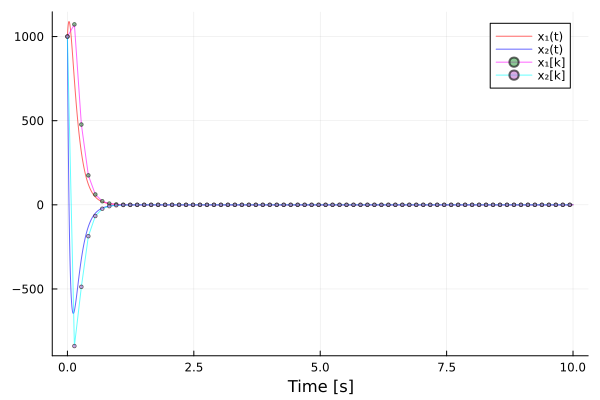

In [15]:
plot(0:hc:T, hcat(xc...)', lab=["x₁(t)" "x₂(t)"], xlabel="Time [s]", linecolor=[:red :blue], alpha=0.6)
plot!(0:hd:T, hcat(xds[12]...)', lab=["x₁[k]" "x₂[k]"], linecolor=[:magenta :cyan], alpha=0.6, marker=:circle, markersize=2)

In [11]:
show(stdout, "text/plain", uds[5])

72-element Vector{Vector{Float64}}:
 [-680.8565087063042]
 [143.61254369692685]
 [102.96912213770334]
 [36.5642892321264]
 [18.658095339745408]
 [9.281428001092305]
 [-0.7687232286037098]
 [1.2814506426320567]
 [0.709456318865744]
 [0.2813089382395579]
 [0.09961523789162102]
 [0.032885702327937506]
 [0.013556402175675808]
 [0.0037486321699337437]
 [0.0012177433337927008]
 [0.000383460185679904]
 [0.0001257180210226845]
 [3.717716725079407e-5]
 [2.0660147452209373e-5]
 [3.95023060149233e-6]
 [7.272133377702848e-7]
 [1.4352943049220593e-7]
 [3.221733025121358e-8]
 [8.356184640263418e-9]
 [2.4281636700096884e-9]
 [8.097148447479902e-10]
 [2.602811643329824e-10]
 [8.53769909859791e-11]
 [2.6730074651039634e-11]
 [8.796384216278394e-12]
 [2.9765503930643956e-12]
 [1.0447203514837066e-12]
 [3.4478341621200866e-13]
 [1.1550509548325888e-13]
 [3.8188053413461535e-14]
 [1.2573649439778227e-14]
 [4.2793841351149794e-15]
 [1.4014212707551635e-15]
 [6.212864614712567e-16]
 [-4.65652599467917e-17]


In [13]:
first_convergence([0.0, 0.0], xds[10], threshold=1e-2)

15